Import needed libraries

In [1]:
import torch
from   torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torchvision.models as models
from   torchvision import transforms
import torch.optim as optim
import pandas as pd
import re
import matplotlib.pyplot as plt
from   PIL import Image
import os

Set the device on GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Download dataset and unzip it

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip '*.zip' && rm *.zip
images_dir = '/content/Images'                  # set the addresses of images folder and captions file
captions_file = '/content/captions.txt'

The function to read captions file and split it to image address and its caption

In [5]:
def dataset_processing(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=0, names=['ImageName', 'Caption'])

    return df

The function to tokenize each caption and return a list of all caption's tokens

In [6]:
def tokenize_filtering(list_of_captions):
    all_tokens = []                                                               # a list to save all of tokens of all captions
    for i, cap in enumerate(list_of_captions):
        lower_cap = cap.lower()                                                   # make all of captions lower case
        list_of_captions[i] = lower_cap
        tokens = re.findall(r'\d+(?:,\d+)*(?:\.\d+)?|\w+', list_of_captions[i])   # tokenize the text with given regular expression
        tokens = ['<sos>'] + tokens + ['<eos>']                                   # add <sos> and <eos> to start and end of each caption's tokens
        all_tokens.append(tokens)

    return all_tokens       # return a list of all captions, each element is a list of a caption's tokens

The function to create a vocabulary of all used tokens in all captions. Each token is a key and it's value is an unique index.

In [7]:
def vocab_creator(all_tokens):
    special_tokens = ['<sos>', '<eos>', '<pad>']
    vocab = {token: idx for idx, token in enumerate(special_tokens)}                          # create a vocab of all including tokens, first add special tokens to vocab
    start_idx = len(vocab)
    vocabs = set(word for sentence in all_tokens for word in sentence) - {'<sos>', '<eos>'}   # create a set of all used tokens in all captions, remove <eos> and <sos> to prevent adding twice
    vocab.update({word: i+start_idx for i, word in enumerate(vocabs)})                        # add each unique token to dictionary of words, each token is a key and it's value is an index

    return vocab

The function to create an embedding for each word using PyTorch's embedding layer

In [8]:
def word_embedding(vocab, all_tokens):
    indexed_sentences = [[vocab[word] for word in sentence] for sentence in all_tokens]                              # convert all_tokens list to it's corresponding index of it's tokens
    max_len = max(len(sentence) for sentence in indexed_sentences)                                                   # find the maximum caption's length for padding
    padded_sentences = [sentence + [vocab['<pad>']] * (max_len - len(sentence)) for sentence in indexed_sentences]   # add <pad> token's index to fill the sentences and make all of them the same length
    padded_tensor = torch.tensor(padded_sentences)                                                                   # convert padded_sentences to PyTorch tensor
    embedding_layer = nn.Embedding(len(vocab), 300)                                                                  # create an embedding layer with vectors of size 300
    word_embeddings = embedding_layer(padded_tensor)                                                                 # get embeddings for each token using padded sentences

    return word_embeddings, padded_sentences

The function to do the operation of converting indexed sequences to original sentences with real words

In [ ]:
def indices_to_words(indices, vocab):
    inv_word_dict = {val: key for key, val in vocab.items()}     # swap the place of indices and words in vocab dict
    return [inv_word_dict[idx] for idx in indices]               # convert given indices to their corresponding sentence

### Caption's Preprocessing

In [9]:
df                     = dataset_processing(captions_file)        # preprocess the caption's file and get the list of captions and images
captions               = df["Caption"]
images                 = df["ImageName"]
all_tokens             = tokenize_filtering(captions)             # tokenize all captions and get a list of all caption's tokens
vocab                  = vocab_creator(all_tokens)                # create a vocabulary of token's and their unique indices
embedding, indexed_seq = word_embedding(vocab, all_tokens)        # get word's embeddings and a list of all indexed tokens of all captions

### Define a sequence of image transformations. 

These transformations are applied to image data to prepare it for input into CNN. Use transform.compose to chain multiple image transformations together. Resizes the input image to size of 224x224 pixels. Convert the image to a PyTorch tensor. Then normalize the image tensor using the specified mean and standard deviation values for each of the 3 color channels. This can help improve the performance and stability of the neural network during training. 

In [12]:
data_transforms = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

### Image Preprocssing

This custom dataset class handles loading and processing of image-caption pairs, applying any specified transformations to the images, and converting the captions into PyTorch tensors.

In [13]:
class ImageCaptionDataset(Dataset):

    # inilializer
    def __init__(self, captions, images, image_folder, transform):
        self.captions = captions                                          # a list of captions corresponding to the images
        self.images= images                                               # a list of image adresses belongs to captions
        self.image_folder = image_folder                                  # folder that contains images
        self.transform = transform                                        # special trainsform which should be applied to the images


    # return the number of items in the dataset, which is the length of the captions list
    def __len__(self):
        return len(self.captions)                                  


    # retrieve an item from the dataset at a specific index
    def __getitem__(self, idx):
        caption = self.captions[idx]                                      # get the wanted caption
        img_name = self.images[idx]                                       # get the name of image that belongs to the caption
        image_path = os.path.join(self.image_folder, img_name)            # get the address of image
        image = Image.open(image_path).convert("RGB")                     # open the image file and convert it to RGB format
        image = self.transform(image)                                     # apply the transformation to the image


        return image, torch.tensor(caption)                               # return a tuple containing the transformed image and the corresponding caption


# create a dataset of pairs of images and their captions
dataset = ImageCaptionDataset(captions=indexed_seq, images=df["ImageName"], image_folder=images_dir, transform=data_transforms)

# set the size of train, test, and validation sets, split to sizes of 0.8, 0.1, 0.1
train_size = int(0.8 * len(dataset))
test_size  = int(0.1 * len(dataset))
val_size   = int(0.1 * len(dataset))

# split the dataset to train, test, and validation sets randomely
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

"""
Create DataLoader for each dataset:
creates DataLoader objects for the training, validation, and test datasets using PyTorch's DataLoader class. 
DataLoader is essential for managing and loading data in batches during training and evaluation of neural networks.
""" 
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)     # load training data in shuffled batches of 32
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)        # load validation data in non-shuffled batches of 32
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)      # load test data in non-shuffled batches of 32



### Q1

### Create Model

This class is designed to generate captions for images by combining image features extracted from a pre-trained ResNet-18 model with text features processed by an LSTM network.

It contains an initializer to set the model, sized and ... . the forward method is used in training mode and uses batches of train data and generates output based on model's weights
 and then in generate caption method, during testing phase a caption is predicted word by word using model's trained weights.

CNN:  A pre-trained ResNet-18 model with the last layer removed to extract features from images. The ResNet layers are frozen to prevent their weights from being updated during training, preserving the pre-trained features.

Embedding: An embedding layer that converts word indices into dense vectors of a size 300.

LSTM: An LSTM network with 256 hidden units that processes sequences of combined image and text features. The input size for the LSTM is the sum of the feature size from ResNet and the embedding dimension.

linear layer: A fully connected layer that maps the LSTM output to the vocabulary size, used to predict the next word in the sequence.

In [ ]:
class ImageCaptioningModel(nn.Module):
    
    # inilializer
    def __init__(self, feature_size, embedding_dim, hidden_size, vocab_size, num_layers):
        super(ImageCaptioningModel, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)                                               # use a pre-trained ResNet-18 model
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-1])                            # Remove the last layer
        for param in self.resnet18.parameters():
            param.requires_grad = False                                                                # freeze ResNet layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)                                       # embedding layer
        self.lstm_input_size = feature_size + embedding_dim        
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True)           # 1-layered LSTM
        self.linear = nn.Linear(hidden_size, vocab_size)                                               # FC layer


    # get train data in batches and generate output of model for that batch
    def forward(self, images, captions):
        batch_size         = images.size(0)
        max_caption_length = captions.size(1)

        image_features = self.resnet18(images).view(batch_size, -1)                               # extract features from images in the batch
        caption_embeddings = self.embedding(captions)                                             # embed the captions
        image_features = image_features.unsqueeze(1).expand(batch_size, max_caption_length, -1)   # expand image features to match the sequence length of captions
        combined_features = torch.cat((image_features, caption_embeddings), dim=2)                # concatenate image features and caption embeddings for feeding to LSTM
        lstm_out, _ = self.lstm(combined_features)                                                # pass combined features to LSTM
        outputs = self.linear(lstm_out)                                                           # generate captions from LSTM outputs

        return outputs


    # generates a caption for a given image (using in testinfg mode)
    def generate_caption(self, image, vocab, max_caption_length=39):
        result_caption = []                                                                       # save predicted caption tokens

        # disable gradient computation, which saves memory and computation during inference
        with torch.no_grad():
            image_features = self.resnet18(image).view(1, -1)                                     # image features are extracted using the ResNet-18 model
            states = None
            caption = torch.tensor([vocab['<sos>']]).unsqueeze(0).to(image.device)                # initialize the LSTM input with the <sos> token

            # iteratively generates words up to max_caption_length
            for _ in range(max_caption_length):
                caption_embedding = self.embedding(caption)                                             # the current caption token is embedded
                combined_features = torch.cat((image_features.unsqueeze(1), caption_embedding), dim=2)  # the embedded caption is concatenated with the image features
                lstm_out, states = self.lstm(combined_features, states)                                 # the concatenated features are passed to the LSTM
                output = self.linear(lstm_out.squeeze(1))                                               # the output is passed to the linear layer to predict the next word
                predicted = output.argmax(1)                                                            # get the predicted token
                result_caption.append(predicted.item())                                                 # add the predicted item to the predicted caption's list

                # the loop breaks if the <eos> token is predicted
                if predicted.item() == vocab['<eos>']:
                    break

                caption = predicted.unsqueeze(0)                                                        # prepare the next input to the LSTM

        return result_caption

### Training The Model

Train the model with batches of data and then update weights. Then use validation data to measure how well the model predicts for val data.

In [ ]:
# parameters to initialize the model
feature_size  = 512
embedding_dim = 300
hidden_size   = 256
vocab_size    = len(vocab)
num_layers    = 1
num_epochs    = 10 

model        = ImageCaptioningModel(feature_size, embedding_dim, hidden_size, vocab_size, num_layers).to(device)   # create the model with given parameters
criterion    = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])                                                    # use CrossEntropy for errors (ignore the padding token for training) 
optimizer    = optim.Adam(model.parameters(), lr=0.001)                                                            # use Adam optimizer
train_losses = []            # save train losses
val_losses   = []            # save val losses

# training phase
for epoch in range(num_epochs):
    model.train()                                                                 # set the model to training mode
    running_loss = 0.0                                                            # save loss of training each batch of data
    for images, captions in train_dataloader:                                     # load a batch of data
        images   = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()                                                     # clear the gradients of all optimized parameters
        outputs = model(images, captions)                                         # pass the images and captions to the model to get the predicted outputs
        targets = captions[:, 1:].contiguous().view(-1)                           # the target captions are shifted by one position because the model's output at each time step should be compared with the next word in the sequence
        outputs = outputs[:, :-1, :].contiguous().view(-1, vocab_size)            # the same as target
        loss    = criterion(outputs, targets)                                     # compute the loss
        loss.backward()                                                           # compute the gradient of the loss
        optimizer.step()                                                          # updates the model parameters based on the computed gradients of loss
        running_loss += loss.item()                                               # add the current batch's loss to total loss of current epoch

    train_loss = running_loss / len(train_dataloader)                             # compute the average loss over all batches in the training epoch
    train_losses.append(train_loss)                                               # save the training loss of current epoch

    model.eval()                                                                  # set the model to evaluation mode
    val_running_loss = 0.0                                                        # save the validation loss over the entire validation set
    with torch.no_grad():                                                         # disable gradient computation
        for images, captions in val_dataloader:                                   # load a batch of data from test data loader
            images   = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions)                                     # pass the images and captions to the model to get the predicted outputs
            targets = captions[:, 1:].contiguous().view(-1)                       # shift as before
            outputs = outputs[:, :-1, :].contiguous().view(-1, vocab_size)
            loss    = criterion(outputs, targets)                                 # calculate loss of the current batch of validation set
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_dataloader)                             # compute the average loss over all batches in the validation epoch
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")         # show the losses after completion of an epoch


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


Epoch [1/10], Train Loss: 4.1333, Val Loss: 3.5141
Epoch [2/10], Train Loss: 3.2960, Val Loss: 3.2128
Epoch [3/10], Train Loss: 2.9916, Val Loss: 3.0671
Epoch [4/10], Train Loss: 2.7853, Val Loss: 2.9895
Epoch [5/10], Train Loss: 2.6233, Val Loss: 2.9418
Epoch [6/10], Train Loss: 2.4864, Val Loss: 2.9187
Epoch [7/10], Train Loss: 2.3687, Val Loss: 2.9068
Epoch [8/10], Train Loss: 2.2690, Val Loss: 2.9115
Epoch [9/10], Train Loss: 2.1832, Val Loss: 2.9157
Epoch [10/10], Train Loss: 2.1073, Val Loss: 2.9355


### Report The train and validation losses during training

The result of the plot shows that during training, the loss on the training set is decreasing. However, the loss on the validation set decreases significantly during the first 4 epochs. After iteration 5 to 10, it doesn't decrease much. We can conclude that we can stop training after 5 epochs. After epoch 9, the loss on the validation set increases, indicating potential overfitting.

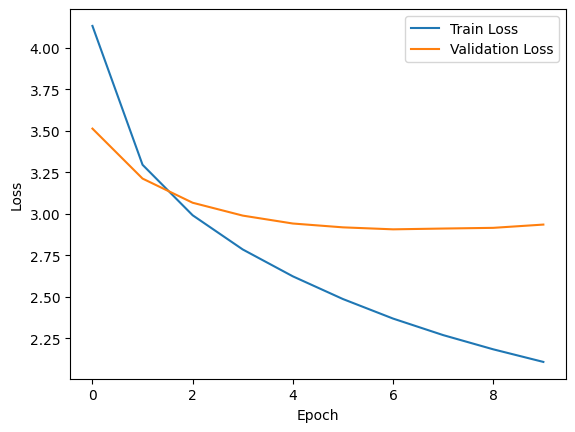

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing phase

Choose n sample data and predict the caption for them using trainged model. Then process them to make them ready for showing.

In [ ]:
# predict the cation for given samples using trained model
def predict(images, captions, model, vocab, num_samples=3):
    for i in range(num_samples):
        image = images[i].cpu().permute(1, 2, 0)                                                   # convert the image to proper format
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # denormalizes the image 
        image = image.clamp(0, 1)                                                                  # clamp to valid range
        all_images.append(image)                                                                   # save the image
        original_caption = indices_to_words(captions[i].cpu().numpy(), vocab)                      # find and save the original caption
        all_oprigins.append(original_caption)
        predicted_caption = model.generate_caption(images[i].unsqueeze(0).to(device), vocab)       # generate the caption using the trained model
        predicted_caption = indices_to_words(predicted_caption, vocab)                             # find and save the predicted caption
        all_predicteds.append(predicted_caption)


model.eval()                                                                                       # set the model to evaluation mode
sample_images, sample_captions = next(iter(test_dataloader))                                       # get a batch of test samples
all_images, all_oprigins, all_predicteds = [], [], []                                              # save images, original caption and presicted caption of samples
predict(sample_images, sample_captions, model, vocab, num_samples=20)                              # predict and 3 sample images with captions

# remove <eos>, <pad> and <sos> tokens from predicted and original captions
for i in range(len(all_oprigins)):
    idx               = all_oprigins[i].index("<eos>")
    all_oprigins[i]   = all_oprigins[i][1:idx]
    all_predicteds[i] = all_predicteds[i][:-1]


### Show 3 samples of test data randomely and show their predicted and original captions

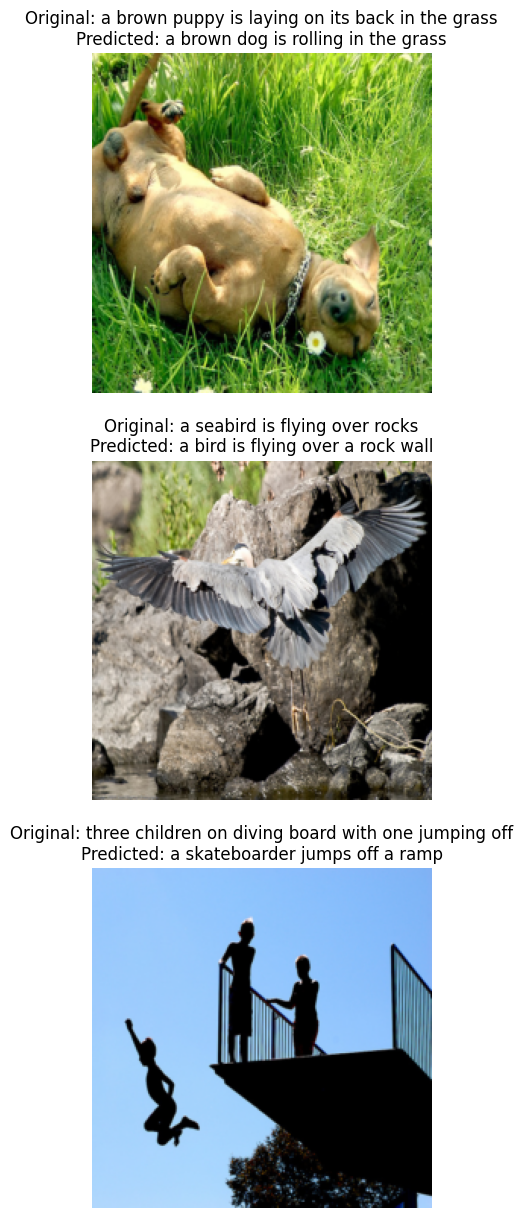

In [ ]:
idxs = [3, 7, 14]                     # random instances
plt.figure(figsize=(15, 5 * 3))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(all_images[idxs[i]])   # show the image
    plt.axis('off')
    plt.title(f"Original: {' '.join(all_oprigins[idxs[i]])}\nPredicted: {' '.join(all_predicteds[idxs[i]])}")   # set the original and predicted caption as the title of plot

plt.show()

### Q2

### Create the Model
The same model with Unfreezed layers of CNN

In [15]:
class ImageCaptioningModelUnfreezed(nn.Module):
    def __init__(self, feature_size, embedding_dim, hidden_size, vocab_size, num_layers):
        super(ImageCaptioningModelUnfreezed, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-1])  # Remove the last layer
        # Unfreeze ResNet layers
        for param in self.resnet18.parameters():
            param.requires_grad = True  # Unfreeze ResNet layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_input_size = feature_size + embedding_dim
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        batch_size = images.size(0)
        max_caption_length = captions.size(1)

        # Extract features from images
        image_features = self.resnet18(images).view(batch_size, -1)  # Shape: (batch_size, 512)

        # Embed the captions
        caption_embeddings = self.embedding(captions)  # Shape: (batch_size, max_caption_length, embedding_dim)

        # Expand image features to match the sequence length of captions
        image_features = image_features.unsqueeze(1).expand(batch_size, max_caption_length, -1)  # Shape: (batch_size, max_caption_length, 512)

        # Concatenate image features and caption embeddings
        combined_features = torch.cat((image_features, caption_embeddings), dim=2)  # Shape: (batch_size, max_caption_length, 512 + embedding_dim)

        # Pass combined features through LSTM
        lstm_out, _ = self.lstm(combined_features)

        # Generate captions from LSTM outputs
        outputs = self.linear(lstm_out)
        return outputs

    def generate_caption(self, image, vocab, max_caption_length=39):
        result_caption = []

        with torch.no_grad():
            image_features = self.resnet18(image).view(1, -1)  # Shape: (1, 512)
            states = None

            # Initialize the LSTM input with the <sos> token
            caption = torch.tensor([vocab['<sos>']]).unsqueeze(0).to(image.device)  # Shape: (1, 1)

            for _ in range(max_caption_length):
                caption_embedding = self.embedding(caption)  # Shape: (1, 1, embedding_dim)
                image_features_expanded = image_features.unsqueeze(1)
                print(image_features_expanded.shape, caption_embedding.shape)
                combined_features = torch.cat((image_features.unsqueeze(1), caption_embedding), dim=2)  # Shape: (1, 1, 512 + embedding_dim)
                lstm_out, states = self.lstm(combined_features, states)  # Shape: (1, 1, hidden_size)
                output = self.linear(lstm_out.squeeze(1))  # Shape: (1, vocab_size)
                predicted = output.argmax(1)  # Shape: (1,)

                result_caption.append(predicted.item())

                # Break if <eos> is predicted
                if predicted.item() == vocab['<eos>']:
                    break

                # Prepare the next input to the LSTM
                caption = predicted.unsqueeze(0)  # Shape: (1, 1)
                print(caption.shape)

        return result_caption

In [16]:
# Example to initialize and use the model
feature_size = 512
embedding_dim = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1

model = ImageCaptioningModelUnfreezed(feature_size, embedding_dim, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])  # Ignore the padding token
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
# Training loop
num_epochs = 10  # Set to your desired number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, captions in train_dataloader:
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(images, captions)

        # Shift targets for the loss computation
        targets = captions[:, 1:].contiguous().view(-1)
        outputs = outputs[:, :-1, :].contiguous().view(-1, vocab_size)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, captions in val_dataloader:
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions)

            # Shift targets for the loss computation
            targets = captions[:, 1:].contiguous().view(-1)
            outputs = outputs[:, :-1, :].contiguous().view(-1, vocab_size)

            loss = criterion(outputs, targets)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


Epoch [1/10], Train Loss: 4.0134, Val Loss: 3.5469
Epoch [2/10], Train Loss: 3.2892, Val Loss: 3.3086
Epoch [3/10], Train Loss: 3.0226, Val Loss: 3.1858
Epoch [4/10], Train Loss: 2.8256, Val Loss: 3.1400
Epoch [5/10], Train Loss: 2.6581, Val Loss: 3.0781
Epoch [6/10], Train Loss: 2.5058, Val Loss: 3.0469
Epoch [7/10], Train Loss: 2.3658, Val Loss: 3.0290
Epoch [8/10], Train Loss: 2.2418, Val Loss: 3.0240
Epoch [9/10], Train Loss: 2.1351, Val Loss: 3.0333
Epoch [10/10], Train Loss: 2.0255, Val Loss: 3.0501


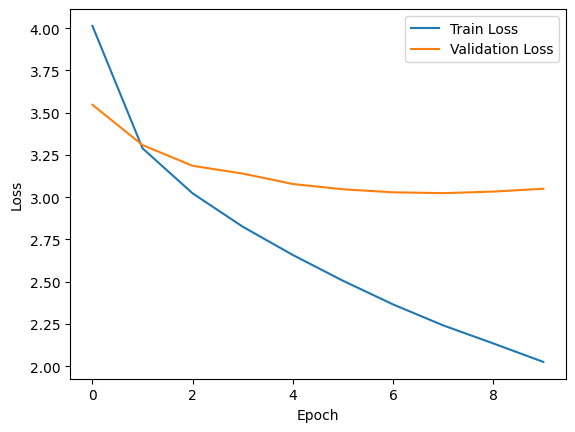

In [17]:
# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')  # If validation is used
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Sample prediction
model.eval()
sample_images, sample_captions = next(iter(test_dataloader))  # Get a batch of test samples
all_images = []
all_oprigins = []
all_predicteds = []
# Display images and their captions
def show_images_with_inference_captions(images, original_captions, model, vocab, num_samples=3):
    # plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # plt.subplot(num_samples, 1, i + 1)
        image = images[i].cpu().permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        image = image.clamp(0, 1)  # Clamp to valid range [0, 1]
        all_images.append(image)
        # plt.imshow(image)
        # plt.axis('off')

        original_caption = indices_to_words(sample_captions[i].cpu().numpy(), vocab)
        all_oprigins.append(original_caption)

        # Generate the caption
        predicted_caption = model.generate_caption(images[i].unsqueeze(0).to(device), vocab)
        predicted_caption = indices_to_words(predicted_caption, vocab)
        all_predicteds.append(predicted_caption)

        # plt.title(f"Original: {' '.join(original_caption)}\nPredicted: {' '.join(predicted_caption)}")

    # plt.show()

# Show 3 sample images with captions
show_images_with_inference_captions(sample_images, sample_captions, model, vocab, num_samples=20)

for i in range(len(all_oprigins)):
  idx = all_oprigins[i].index("<eos>")
  all_oprigins[i] = all_oprigins[i][1:idx]
  all_predicteds[i] = all_predicteds[i][:-1]


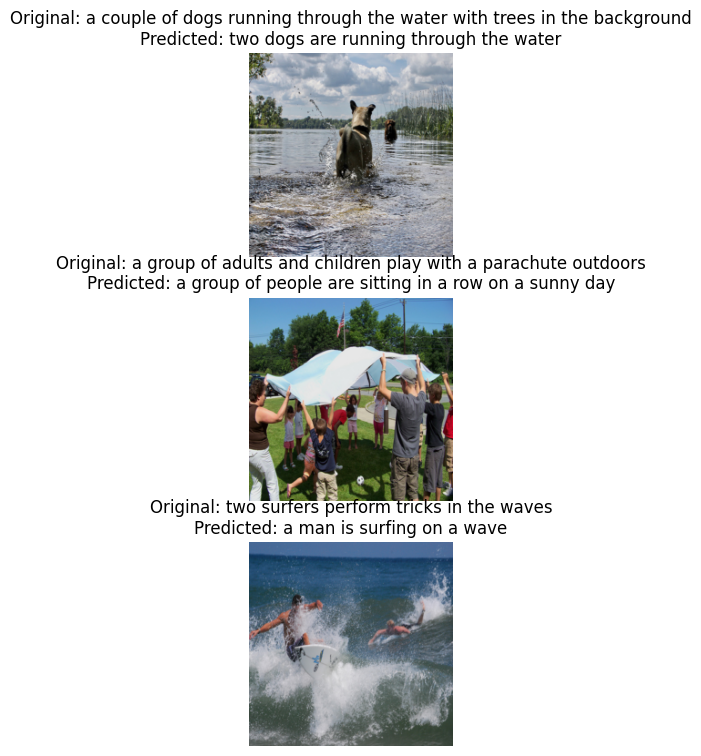

In [21]:
idxs = [5, 6, 12]
plt.figure(figsize=(15, 3 * 3))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(all_images[idxs[i]])
    plt.axis('off')


    plt.title(f"Original: {' '.join(all_oprigins[idxs[i]])}\nPredicted: {' '.join(all_predicteds[idxs[i]])}")

plt.show()